In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta
from matplotlib import pyplot as plt
from os import listdir, path

In [2]:
for daydir in sorted(listdir('tobac')):
    dataset_path = 'tobac/' + daydir + '/Features.nc'
    if path.exists(dataset_path):
        dataset = xr.open_dataset(dataset_path)
        try:
            total_cell_area = dataset.areas.data.sum() * 0.25
            print(daydir, total_cell_area)
        except AttributeError as e:
            continue

tobac_Save_20220621 270746.0
tobac_Save_20220622 119012.5
tobac_Save_20220626 51929.75
tobac_Save_20220711 475220.0
tobac_Save_20220713 327120.25
tobac_Save_20220727 272029.25
tobac_Save_20220728 192420.0
tobac_Save_20220730 282505.5
tobac_Save_20220807 287297.25
tobac_Save_20220808 151220.0
tobac_Save_20220809 287535.25
tobac_Save_20220810 816660.0
tobac_Save_20220826 1159782.5
tobac_Save_20220828 225161.75
tobac_Save_20220906 1494992.0
tobac_Save_20220917 138566.75
tobac_Save_20220918 78037.5
tobac_Save_20220919 132576.25
tobac_Save_20220925 72635.0


In [3]:
abl_heights = pd.read_csv('abl_heights.csv')
tamu_soundings = abl_heights.where(abl_heights['filename'].str.contains('SHARPPY')).dropna()
tamu_soundings['date'] = tamu_soundings['filename'].apply(lambda x: dt.strptime(x.split('_')[2], '%Y%m%d'))
tamu_soundings
arm_soundings = abl_heights.where(abl_heights['filename'].str.contains('housonde')).dropna()
arm_soundings['date'] = arm_soundings['filename'].apply(lambda x: dt.strptime(x.split('.')[2], '%Y%m%d'))
abl_heights = pd.concat([tamu_soundings, arm_soundings])
abl_heights

,filename,abl_height,air_mass,date
0,TAMU_TRACER_20220602_2028_95.93W_30.07N_SHARPP...,1452.713524,continental,2022-06-02
1,TAMU_TRACER_20220602_2330_95.93W_30.07N_SHARPP...,1891.299142,continental,2022-06-02
2,TAMU_TRACER_20220621_1857_95.93W_30.07N_SHARPP...,1041.044680,continental,2022-06-21
3,TAMU_TRACER_20220621_2159_95.93W_30.07N_SHARPP...,1954.365196,continental,2022-06-21
4,TAMU_TRACER_20220622_2041_95.93W_30.07N_SHARPP...,1575.348554,continental,2022-06-22
...,...,...,...,...
61,housondewnpnM1.b1.20220712.233100.cdf,782.031278,maritime,2022-07-12
62,housondewnpnM1.b1.20220810.203100.cdf,490.474155,maritime,2022-08-10
63,housondewnpnM1.b1.20220822.203000.cdf,682.416722,maritime,2022-08-22
64,housondewnpnS4.b1.20220822.190000.cdf,1654.849482,maritime,2022-08-22


In [4]:
total_areas = []
abl_differences = []
npdates = []
pydates = []

abl_heights.groupby('date')
for x in abl_heights.groupby('date'):
    date_df = x[1]
    if 'continental' in date_df['air_mass'].values and 'maritime' in date_df['air_mass'].values:
        maritime_abl_height = date_df[date_df['air_mass'] == 'maritime']['abl_height'].values[0]
        continental_abl_height = date_df[date_df['air_mass'] == 'continental']['abl_height'].values[0]
        diff = continental_abl_height - maritime_abl_height
        daydir = x[0].strftime('tobac_Save_%Y%m%d')
        dataset_path = 'tobac/' + daydir + '/Features.nc'
        if path.exists(dataset_path):
            dataset = xr.open_dataset(dataset_path)
            try:
                total_cell_area = dataset.areas.data.sum() * 0.25
                total_areas.append(total_cell_area)
                abl_differences.append(diff)
                npdates.append(x[0].to_datetime64())
                pydates.append(x[0].to_pydatetime())
            except AttributeError as e:
                continue
                print(x[0], 'failed')
        else:
            print(x[0], 'no tobac')
    else:
        continue
        print(x[0], 'missing data')

2022-07-12 00:00:00 no tobac
2022-07-29 00:00:00 no tobac


In [5]:
pydates

[datetime.datetime(2022, 6, 21, 0, 0),
 datetime.datetime(2022, 6, 22, 0, 0),
 datetime.datetime(2022, 6, 26, 0, 0),
 datetime.datetime(2022, 7, 11, 0, 0),
 datetime.datetime(2022, 7, 13, 0, 0),
 datetime.datetime(2022, 7, 27, 0, 0),
 datetime.datetime(2022, 7, 28, 0, 0),
 datetime.datetime(2022, 7, 30, 0, 0),
 datetime.datetime(2022, 8, 7, 0, 0),
 datetime.datetime(2022, 8, 8, 0, 0),
 datetime.datetime(2022, 8, 9, 0, 0),
 datetime.datetime(2022, 8, 10, 0, 0),
 datetime.datetime(2022, 8, 26, 0, 0),
 datetime.datetime(2022, 8, 28, 0, 0),
 datetime.datetime(2022, 9, 6, 0, 0),
 datetime.datetime(2022, 9, 17, 0, 0),
 datetime.datetime(2022, 9, 18, 0, 0),
 datetime.datetime(2022, 9, 19, 0, 0),
 datetime.datetime(2022, 9, 25, 0, 0)]

In [6]:
ltg_dates = []
ltg_sources = []
ltg_abl_diffs = []

for i in range(len(pydates)):
    date = pydates[i]
    abl_diff = abl_differences[i]
    tomorrow = date + timedelta(days=1)
    today_parent = path.join('/Volumes/LtgSSD', date.strftime('%-m'), '6sensor_minimum')
    ltg_today = path.join(today_parent, date.strftime('LYLOUT_%y%m%d_000000_86400_map500m.nc'))
    tomorrow_parent = path.join('/Volumes/LtgSSD', tomorrow.strftime('%-m'), '6sensor_minimum')
    ltg_tomorrow = path.join(tomorrow_parent, tomorrow.strftime('LYLOUT_%y%m%d_000000_86400_map500m.nc'))
    if path.exists(ltg_today) and path.exists(ltg_tomorrow):
        ds_today = xr.open_dataset(ltg_today)
        today_events = np.sum(ds_today['event_time'].data > np.array([date.replace(hour=12, minute=0, second=0)]).astype('datetime64[s]')[0])
        ds_tomorrow = xr.open_dataset(ltg_tomorrow)
        tomorrow_events = np.sum(ds_tomorrow['event_time'].data < np.array([tomorrow.replace(hour=6, minute=0, second=0)]).astype('datetime64[s]')[0])
        ltg_dates.append(date)
        ltg_sources.append(today_events + tomorrow_events)
        ltg_abl_diffs.append(abl_diff)
    else:
        print(date, 'missing')

2022-06-22 00:00:00 missing
2022-06-26 00:00:00 missing
2022-09-17 00:00:00 missing
2022-09-18 00:00:00 missing


In [7]:
indices_to_exclude = [8, 6, 4]
for i in indices_to_exclude:
    total_areas.pop(i)
    abl_differences.pop(i)
    pydates.pop(i)
    npdates.pop(i)

Text(0, 0.5, 'Difference in ABL Height,\ncontinental - maritime (m)')

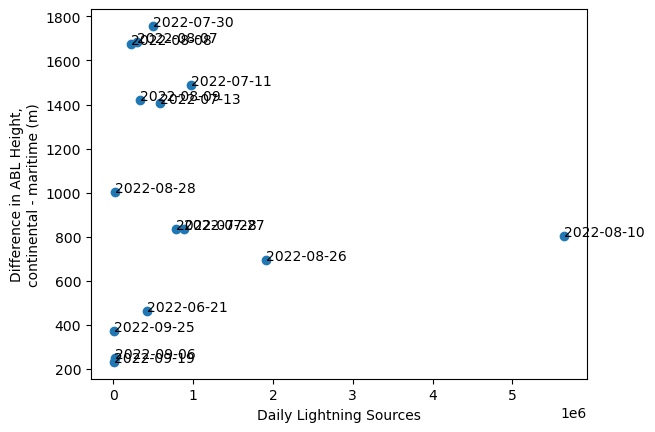

In [8]:
ltg_fig = plt.figure()
ltg_ax = ltg_fig.add_subplot(111)
ltg_ax.scatter(ltg_sources, ltg_abl_diffs)
[ltg_ax.text(ltg_sources[i], ltg_abl_diffs[i], ltg_dates[i].strftime('%Y-%m-%d')) for i in range(len(ltg_dates))]
ltg_ax.set_xlabel('Daily Lightning Sources')
ltg_ax.set_ylabel('Difference in ABL Height,\ncontinental - maritime (m)')

Text(0, 0.5, 'Difference in ABL Height,\ncontinental - maritime (m)')

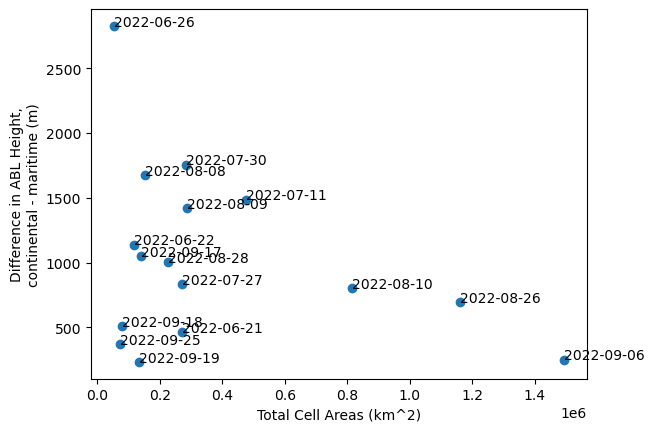

In [27]:
fig = plt.figure()
ax = fig.gca()
ax.scatter(total_areas, abl_differences)
[ax.text(total_areas[i], abl_differences[i], pydates[i].strftime('%Y-%m-%d')) for i in range(len(total_areas))]
ax.set_xlabel('Total Cell Areas (km^2)')
ax.set_ylabel('Difference in ABL Height,\ncontinental - maritime (m)')

In [13]:
from scipy import stats

res = stats.linregress(np.array(total_areas), np.array(abl_differences))

fit_line_x = np.arange(np.min(total_areas), np.max(total_areas), 1)
fit_line_y = res.intercept +  res.slope * fit_line_x

In [26]:
res

LinregressResult(slope=-0.0005360451501772645, intercept=1234.2620679447477, rvalue=-0.32919133531665434, pvalue=0.21312608694436547, stderr=0.00041094342886558723, intercept_stderr=227.907457387651)

In [14]:
ax.plot(fit_line_x, fit_line_y)

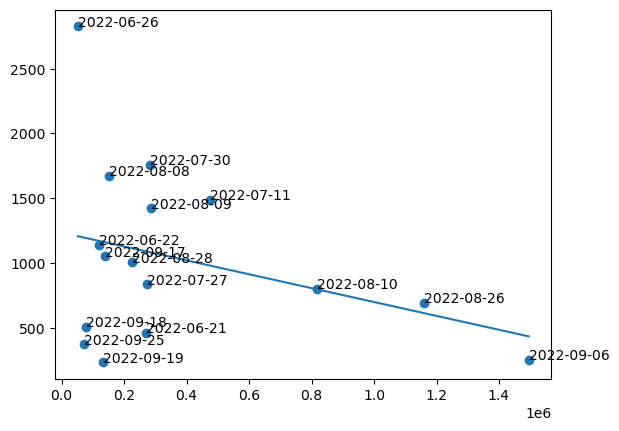

In [15]:
fig

In [16]:
res

LinregressResult(slope=-0.0005360451501772645, intercept=1234.2620679447477, rvalue=-0.32919133531665434, pvalue=0.21312608694436547, stderr=0.00041094342886558723, intercept_stderr=227.907457387651)

In [17]:
def model_func(x, a, b, c):
    return a + b*x**(-1)

from scipy.optimize import curve_fit
res2 = curve_fit(model_func, np.array(total_areas), np.array(abl_differences))
res2

/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([7.47566910e+02, 4.58754263e+07, 1.00000000e+00]),
 array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))

In [18]:
res2_line = res2[0][0] + res2[0][1] / fit_line_x
ax.plot(fit_line_x, res2_line)

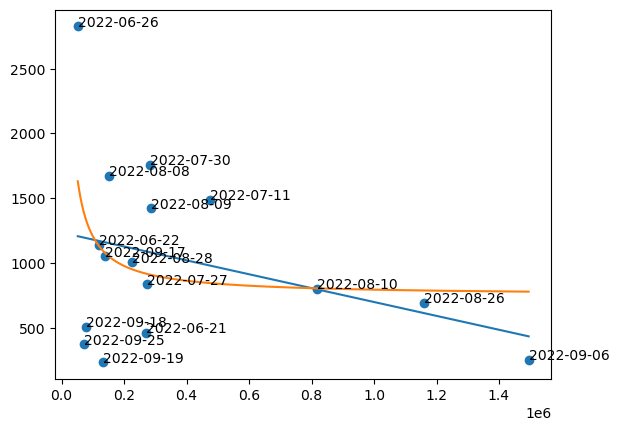

In [19]:
fig

In [20]:
pydates

[datetime.datetime(2022, 6, 21, 0, 0),
 datetime.datetime(2022, 6, 22, 0, 0),
 datetime.datetime(2022, 6, 26, 0, 0),
 datetime.datetime(2022, 7, 11, 0, 0),
 datetime.datetime(2022, 7, 27, 0, 0),
 datetime.datetime(2022, 7, 30, 0, 0),
 datetime.datetime(2022, 8, 8, 0, 0),
 datetime.datetime(2022, 8, 9, 0, 0),
 datetime.datetime(2022, 8, 10, 0, 0),
 datetime.datetime(2022, 8, 26, 0, 0),
 datetime.datetime(2022, 8, 28, 0, 0),
 datetime.datetime(2022, 9, 6, 0, 0),
 datetime.datetime(2022, 9, 17, 0, 0),
 datetime.datetime(2022, 9, 18, 0, 0),
 datetime.datetime(2022, 9, 19, 0, 0),
 datetime.datetime(2022, 9, 25, 0, 0)]

In [21]:
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES

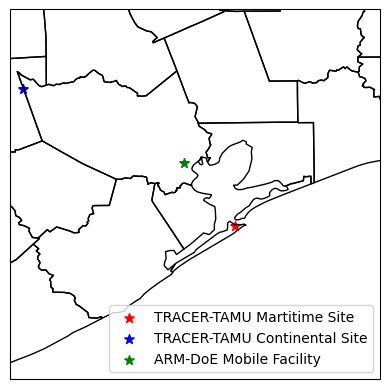

In [22]:
map_fig = plt.figure()
map_ax = map_fig.add_subplot(111, projection=ccrs.PlateCarree())

map_ax.add_feature(USCOUNTIES.with_scale('5m'))
map_ax.scatter([-94.78], [29.33], s=50, c='red', marker='*', label='TRACER-TAMU Martitime Site', transform=ccrs.PlateCarree())
map_ax.scatter([-95.93], [30.07], s=50, c='blue', marker='*', label='TRACER-TAMU Continental Site', transform=ccrs.PlateCarree())
map_ax.scatter([-95.06], [29.67], s=50, c='green', marker='*', label='ARM-DoE Mobile Facility', transform=ccrs.PlateCarree())
map_ax.set_extent([-96, -94., 28.5, 30.5])
map_ax.legend(loc='lower right')

In [23]:
import xarray as xr

In [24]:
armloc = xr.open_dataset('armdata/housondewnpnM1.b1.20220531.233000.cdf')

In [25]:
armloc.lat.data[0], armloc.lon.data[0]

(29.67, -95.06)